In [1]:
%pip install tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import os
import json

  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached grpcio-1.71.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached numpy-2.1.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached h5py-3.13.0-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached charset_normalizer-3.4.1-cp312-cp312-win_amd64.whl.metadata (36 kB)
  Using cached idna-3.10-p


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Dataset path
DATASET_DIR = "dataset"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5  # You can increase later if needed

In [3]:
# Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [4]:
from PIL import Image
import os

def remove_broken_images(folder_path):
    removed = 0
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                img = Image.open(file_path)
                img.verify()  # This will raise an exception for corrupt images
            except Exception as e:
                if os.path.exists(file_path):  # Check if the file exists
                    print(f"Removing broken image: {file_path}")
                    os.remove(file_path)
                else:
                    print(f"File not found, skipping: {file_path}")
                removed += 1
    print(f"✅ Removed {removed} broken images.")

remove_broken_images("dataset")


✅ Removed 0 broken images.


In [5]:
# ── Create the training generator ────────────────────────────────────────────
train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='training'
)

Found 557 images belonging to 9 classes.


In [6]:
# ── SAVE the mapping from class name → index ─────────────────────────────────
os.makedirs("models", exist_ok=True)               # ensure folder exists
with open("models/skin_class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)
print("Saved class_indices mapping:", train_generator.class_indices)

Saved class_indices mapping: {'Actinic keratosis': 0, 'Atopic Dermatitis': 1, 'Benign keratosis': 2, 'Dermatofibroma': 3, 'Melanocytic nevus': 4, 'Melanoma': 5, 'Squamous cell carcinoma': 6, 'Tinea Ringworm Candidiasis': 7, 'Vascular lesion': 8}


In [7]:
# Validation generator
val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 139 images belonging to 9 classes.


In [8]:
# Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train!
model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Save model
model.save("models/skin_model.keras")
print("✅ Model saved at models/skin_model.h5")


c:\Users\DELL\Disease-Prediction-using-Machine-Learning\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 864ms/step - accuracy: 0.1901 - loss: 2.3192 - val_accuracy: 0.5252 - val_loss: 1.4778
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 666ms/step - accuracy: 0.5438 - loss: 1.3583 - val_accuracy: 0.6691 - val_loss: 1.1115
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 713ms/step - accuracy: 0.7160 - loss: 0.9602 - val_accuracy: 0.6691 - val_loss: 0.9621
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 753ms/step - accuracy: 0.7564 - loss: 0.8125 - val_accuracy: 0.6763 - val_loss: 0.9136
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 732ms/step - accuracy: 0.7431 - loss: 0.7962 - val_accuracy: 0.6978 - val_loss: 0.8445
✅ Model saved at models/skin_model.h5


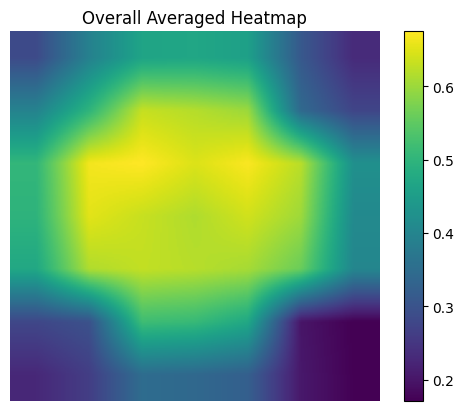

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

IMAGE_SIZE = (224, 224)

def get_heatmap_array(img_path, model, last_conv_layer_name):
    try:
        # Preprocess
        img = image.load_img(img_path, target_size=IMAGE_SIZE)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Grad-CAM setup
        grad_model = Model(inputs=model.input,
                           outputs=[model.get_layer(last_conv_layer_name).output, model.output])

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            pred_index = tf.argmax(predictions[0])
            class_channel = predictions[:, pred_index]

        grads = tape.gradient(class_channel, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / np.max(heatmap)

        # Resize to uniform size (224x224)
        heatmap = tf.image.resize(heatmap[..., tf.newaxis], IMAGE_SIZE).numpy().squeeze()
        return heatmap

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

# Accumulate all heatmaps
heatmaps = []
root_dir = "dataset"
for class_folder in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_folder)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, filename)
                heatmap = get_heatmap_array(img_path, model, last_conv_layer_name="Conv_1")
                if heatmap is not None:
                    heatmaps.append(heatmap)

# Average heatmap
if heatmaps:
    avg_heatmap = np.mean(np.stack(heatmaps), axis=0)

    # Display averaged heatmap
    plt.imshow(avg_heatmap, cmap='viridis')
    plt.colorbar()
    plt.title("Overall Averaged Heatmap")
    plt.axis('off')
    plt.show()
else:
    print("No heatmaps were generated.")
